### Importing library


In [1]:
import numpy as np
import datetime
import threading
import multiprocessing as mp
from matplotlib import pyplot as plt
from time import time
from scipy.stats import norm
%matplotlib inline
plt.style.use('bmh')

### Defineing diffusivity profile

In [2]:
import sympy
#sympy.init_printing()

z = sympy.symbols('z')

K0 = 1e-3# m * * 2 / s
K1 = 6e-3# m / s
Aalpha = 0.5
c=20
w=0

sym_Diffu =  K0 + K1 * z * sympy.exp(-Aalpha * z) + K1/c*(1-sympy.tanh(c*z))
sym_dKdz = sympy.diff(sym_Diffu, z, 1)
sym_Beta = sympy.sqrt(2 * sym_Diffu)
sym_dBdz = sympy.diff(sym_Beta, z, 1)
sym_ddBdzz = sympy.diff(sym_Beta, z, 2)
sym_Alpha = w + sym_dKdz
sym_dAdz = sympy.diff(sym_Alpha, z, 1)
sym_ddAdzz = sympy.diff(sym_Alpha, z, 2)
sym_dABdz = sympy.diff(sym_Alpha * sym_Beta, z, 1)

Diffu  =  sympy.utilities.lambdify(z,          sym_Diffu,np)
dKdz   =  sympy.utilities.lambdify(z,          sym_dKdz,np)
Beta   =  sympy.utilities.lambdify(z,          sym_Beta,np)
dBdz   =  sympy.utilities.lambdify(z,          sym_dBdz,np)
ddBdzz=  sympy.utilities.lambdify(z,          sym_ddBdzz,np)
Alpha =  sympy.utilities.lambdify(z,      sym_Alpha,np)
dAdz  =  sympy.utilities.lambdify(z,      sym_dAdz,np)
ddAdzz=  sympy.utilities.lambdify(z,      sym_ddAdzz,np)
dABdz =  sympy.utilities.lambdify(z, sym_Alpha*sym_Beta,np)


In [3]:
print(sym_Diffu)

0.006*z*exp(-0.5*z) - 0.0003*tanh(20*z) + 0.0013


### Defineing lagrangian schemes

In [8]:
#######
#Euler#
#######
def step_e(z,H,dt,N_sample):
    
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    
    a=dKdz(z)
    b=np.sqrt(2*Diffu(z))
    
    temp=z+a*dt+b*dW
    temp=np.where(temp<0, -temp ,temp)
    temp=np.where(temp>H, 2*H-temp,temp)
    return temp

def step_e_Test1(z,H,dt,N_sample):
    
    
    a=dKdz(z)
    
    temp=z+a*dt
    temp=np.where(temp<0, -temp ,temp)
    temp=np.where(temp>H, 2*H-temp,temp)
    return temp

def step_e_Test2(z,H,dt,N_sample):
    
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    
    b=np.sqrt(2*Diffu(z))
    
    temp=z+b*dW
    temp=np.where(temp<0, -temp ,temp)
    temp=np.where(temp>H, 2*H-temp,temp)
    return temp

def step_e_const(z,H,dt,N_sample):
    
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    K0=3e-3
    b=np.sqrt(2*K0)
    
    temp=z+b*dW
    temp=np.where(temp<0, -temp ,temp)
    temp=np.where(temp>H, 2*H-temp,temp)
    return temp

########
#Visser#
########
def step_v(z,H,dt,N_sample):
    
    #dW=np.random.uniform(-1,1,N_sample)
    #r=1/3
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    r=dt
    
    a=dKdz(z)
    G=Diffu(z+a*dt/2)
    
    temp= z + a*dt + np.sqrt(2/r*dt*G)*dW
    temp=np.where(temp<0, -temp ,temp)
    temp=np.where(temp>H, 2*H-temp,temp)
    return temp

def step_v_const(z,H,dt,N_sample):
    K0=3e-3
    
    #dW=np.random.uniform(-1,1,N_sample)
    #r=1/3
    
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    r=dt
    
    temp= z + np.sqrt(2/r*dt*K0)*dW
    temp=np.where(temp<0, -temp ,temp)
    temp=np.where(temp>H, 2*H-temp,temp)
    return temp

##############
#Milstein 1nd#
##############
def step_m(z,H,dt,N_sample):
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    temp= z + (1/2)*dKdz(z)*(dW*dW+dt) + Beta(z)*dW
    temp=np.where(temp<0, -temp ,temp)
    temp=np.where(temp>H, 2*H-temp,temp)
    return temp

##############
#Milstein 2nd#
##############
def step_m2(z,H,dt,N_sample):
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    
    k=Diffu(z)
    dkdz=dKdz(z)
    ddkdz=dAdz(z)
    dddkdz=ddAdzz(z)
    sqrt2k=np.sqrt(2*k)
    
    a=dkdz
    da=ddkdz
    dda=dddkdz
    b= sqrt2k 
    db=dkdz/b
    ddb=ddkdz/b - ((dkdz)**2)/b**3
    ab=da*b+a*db
    
    temp= z + a*dt+b*dW+1/2*b*db*(dW*dW-dt)+1/2*(ab+1/2*ddb*b**2)*dW*dt+\
            1/2*(a*da+1/2*dda*b**2)*dt**2
    
    temp=np.where(temp<0, -temp ,temp)
    temp=np.where(temp>H, 2*H-temp,temp)
    return temp

def step_m2_const(z,H,dt,N_sample):
    
    K0=3e-3
    dW=np.random.normal(0,np.sqrt(dt),N_sample)
    temp= z +np.sqrt(2*K0)*dW
    temp=np.where(temp<0, -temp ,temp)
    temp=np.where(temp>H, 2*H-temp,temp)
    return temp

### Defineing functions for time adaptive

In [33]:
def oneStep(upperBound, lowerBound, TimeAdaptive, scheme, rFactor ,H, dt):
    
    maskBody=((upperBound<TimeAdaptive)&(lowerBound>TimeAdaptive))

    zBody=TimeAdaptive[maskBody]
    zBody=scheme(zBody, H, dt, zBody.size)

    zEdge=TimeAdaptive[~maskBody]
    for j in range(rFactor):
        zEdge=scheme(zEdge,H,dt/rFactor,zEdge.size)

    TimeAdaptive[maskBody]=zBody
    TimeAdaptive[~maskBody]=zEdge
    
    return None

def parallelBodyEdge(Tmax, dt, H, prosent, rFactor, Testdepth, Np, Nbins,
                     queneEu, queneEuConst, queneV, queneVConst, queneM, queneM2, queneM2Const):
    np.random.seed()
    upperBound =H*prosent
    lowerBound =H-H*prosent
    Ntime   =int(Tmax/dt)  

    hist_E_timeAdap      =np.zeros((Nbins-1,),'i')
    hist_V_timeAdap      =np.zeros((Nbins-1,),'i')
    hist_M_timeAdap      =np.zeros((Nbins-1,),'i')
    hist_M2_timeAdap     =np.zeros((Nbins-1,),'i')
    hist_EConst_timeAdap =np.zeros((Nbins-1,),'i')
    hist_VConst_timeAdap =np.zeros((Nbins-1,),'i')
    hist_MConst_timeAdap =np.zeros((Nbins-1,),'i')

    zEulTimeAdaptive    =np.random.uniform(0,H,int(Np))
    zVisTimeAdaptive    =np.random.uniform(0,H,int(Np))
    zMilTimeAdaptive    =np.random.uniform(0,H,int(Np))
    zMil2TimeAdaptive   =np.random.uniform(0,H,int(Np))
    zEulConTimeAdaptive =np.random.uniform(0,H,int(Np))
    zVisConTimeAdaptive =np.random.uniform(0,H,int(Np))
    zMilConTimeAdaptive =np.random.uniform(0,H,int(Np))

    for i in range(Ntime):

        oneStep(upperBound, lowerBound, zEulTimeAdaptive,    step_e,        rFactor ,H, dt)
        oneStep(upperBound, lowerBound, zVisTimeAdaptive,    step_v,        rFactor ,H, dt)
        oneStep(upperBound, lowerBound, zMilTimeAdaptive,    step_m,        rFactor ,H, dt)
        oneStep(upperBound, lowerBound, zMil2TimeAdaptive,   step_m2,       rFactor ,H, dt)
        oneStep(upperBound, lowerBound, zEulConTimeAdaptive, step_e_const,  rFactor ,H, dt)
        oneStep(upperBound, lowerBound, zVisConTimeAdaptive, step_v_const,  rFactor ,H, dt)
        oneStep(upperBound, lowerBound, zMilConTimeAdaptive, step_m2_const, rFactor ,H, dt)

        #Adding the histogram
        ###
        temp0, _ = np.histogram(zEulTimeAdaptive, bins = np.linspace(0, Testdepth, Nbins))
        hist_E_timeAdap=hist_E_timeAdap + temp0

        temp1, _ = np.histogram(zVisTimeAdaptive, bins = np.linspace(0, Testdepth, Nbins))
        hist_V_timeAdap=hist_V_timeAdap + temp1

        temp2, _ = np.histogram(zMilTimeAdaptive, bins = np.linspace(0, Testdepth, Nbins))
        hist_M_timeAdap=hist_M_timeAdap + temp2

        temp3, _ = np.histogram(zMil2TimeAdaptive, bins = np.linspace(0, Testdepth, Nbins))
        hist_M2_timeAdap=hist_M2_timeAdap + temp3

        ### Constant potensial
        temp4, _ = np.histogram(zEulConTimeAdaptive, bins = np.linspace(0, Testdepth, Nbins))
        hist_EConst_timeAdap=hist_EConst_timeAdap+temp4

        temp5, _ = np.histogram(zVisConTimeAdaptive, bins = np.linspace(0, Testdepth, Nbins))
        hist_VConst_timeAdap=hist_VConst_timeAdap+temp5

        temp6, _ = np.histogram(zMilConTimeAdaptive, bins = np.linspace(0, Testdepth, Nbins))
        hist_MConst_timeAdap=hist_MConst_timeAdap+temp6

        if (i % int(Ntime/100) ==0):
            print("\r %6.2f"% (i*100/Ntime+1),"%", end="\r",flush=True)
            
    queneEu.put(hist_E_timeAdap)
    queneEuConst.put(hist_EConst_timeAdap)
    queneV.put(hist_V_timeAdap)
    queneVConst.put(hist_VConst_timeAdap)
    queneM.put(hist_M_timeAdap)
    queneM2.put(hist_M2_timeAdap)
    queneM2Const.put(hist_MConst_timeAdap)
            
    return None
        
def RunSimulation(NumberOfThread, Tmax, dt, H, prosent, rFactor, Testdepth, Np, Nbins):
    print("Total number of process: ", NumberOfThread)
    SubNp     = np.full((NumberOfThread,), int(Np/NumberOfThread))
    SubNp[-1] = SubNp[-1] + (Np%NumberOfThread)                 

    Ntime     = int(Tmax/dt)  #Number of time interval
    counter=Ntime

    if (__name__ == '__main__'):
        threads=[]
        queneEu=      mp.Queue()
        queneEuConst= mp.Queue()
        queneV=       mp.Queue()
        queneVConst=  mp.Queue()
        queneM=       mp.Queue()
        queneM2=      mp.Queue()
        queneM2Const= mp.Queue()

        for i in range(NumberOfThread):
            thread = mp.Process(target= parallelBodyEdge, 
                                args= (Tmax, dt, H, prosent, rFactor, Testdepth, SubNp[i], Nbins,
                                       queneEu, queneEuConst, queneV, queneVConst, queneM, queneM2, queneM2Const))
            threads.append(thread)
            thread.start()    #starting calculation.

        for thread in threads:  
            thread.join()     #waiting these processes finish. 

    hist_E_timeAdap      = np.zeros((Nbins-1,),'i')
    hist_EConst_timeAdap = np.zeros((Nbins-1,),'i')
    hist_V_timeAdap      = np.zeros((Nbins-1,),'i')
    hist_VConst_timeAdap = np.zeros((Nbins-1,),'i')
    hist_M_timeAdap      = np.zeros((Nbins-1,),'i')
    hist_M2_timeAdap     = np.zeros((Nbins-1,),'i')
    hist_MConst_timeAdap = np.zeros((Nbins-1,),'i')

    for i in range(NumberOfThread):
        hist_E_timeAdap      += queneEu.get()
        hist_EConst_timeAdap += queneEuConst.get()
        hist_V_timeAdap      += queneV.get()
        hist_VConst_timeAdap += queneVConst.get()
        hist_M_timeAdap      += queneM.get()
        hist_M2_timeAdap     += queneM2.get()
        hist_MConst_timeAdap += queneM2Const.get()

    hist_E_timeAdap  =hist_E_timeAdap  /counter
    hist_V_timeAdap  =hist_V_timeAdap  /counter
    hist_M_timeAdap  =hist_M_timeAdap  /counter
    hist_M2_timeAdap =hist_M2_timeAdap /counter
    hist_EConst_timeAdap  =hist_EConst_timeAdap  /counter
    hist_VConst_timeAdap  =hist_VConst_timeAdap  /counter
    hist_MConst_timeAdap  =hist_MConst_timeAdap  /counter

    hist_E_timeAdap  =hist_E_timeAdap  /np.mean(hist_E_timeAdap)
    hist_V_timeAdap  =hist_V_timeAdap  /np.mean(hist_V_timeAdap)
    hist_M_timeAdap  =hist_M_timeAdap  /np.mean(hist_M_timeAdap)
    hist_M2_timeAdap =hist_M2_timeAdap /np.mean(hist_M2_timeAdap)
    hist_EConst_timeAdap  =hist_EConst_timeAdap  /np.mean(hist_EConst_timeAdap)
    hist_VConst_timeAdap  =hist_VConst_timeAdap  /np.mean(hist_VConst_timeAdap)
    hist_MConst_timeAdap  =hist_MConst_timeAdap  /np.mean(hist_MConst_timeAdap)
    
    lists=[]
    lists.append(hist_E_timeAdap)
    lists.append(hist_V_timeAdap)
    lists.append(hist_M_timeAdap)
    lists.append(hist_M2_timeAdap)
    lists.append(hist_EConst_timeAdap)
    lists.append(hist_VConst_timeAdap)
    lists.append(hist_MConst_timeAdap)
    
    return lists

### BinaryTimeApative Method

In [39]:
Np        = 20000
Nbins     = 200
Tmax      = 1*3600          #Maximum time
dt        = 0.1             #Delta time
H         = 10
prosent   = 0.01
rFactor   = 1
Testdepth = 2
NumberOfThread = 4

startTime=time()
lists = RunSimulation(NumberOfThread, Tmax, dt, H, prosent, rFactor, Testdepth, Np, Nbins)
endTime=time()
print("Time elapsed: ", endTime-startTime)

hist_E_timeAdap      = lists[0]
hist_V_timeAdap      = lists[1]
hist_M_timeAdap      = lists[2]
hist_M2_timeAdap     = lists[3]
hist_EConst_timeAdap = lists[4]
hist_VConst_timeAdap = lists[5]
hist_MConst_timeAdap = lists[6]

Total number of process:  4
Time elapsed:  364.8162360191345


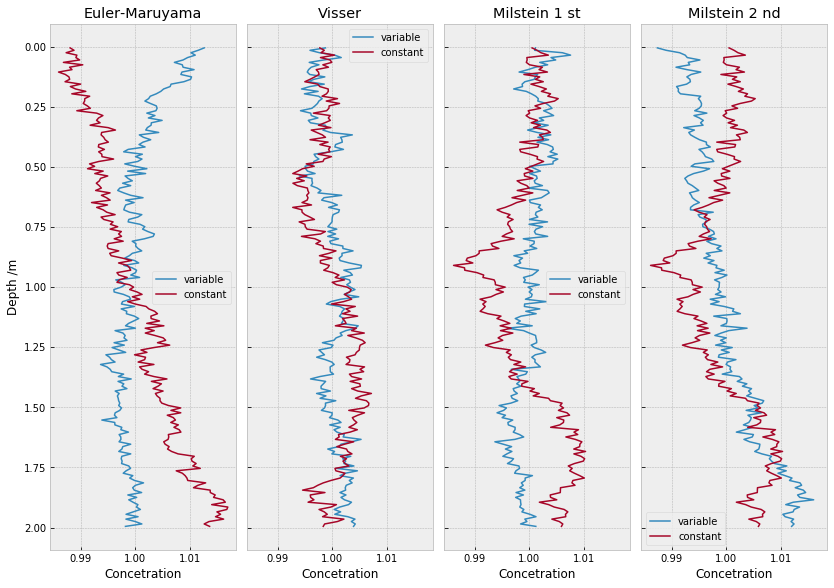

In [40]:
bins = np.linspace(0, Testdepth, Nbins)
midpoints = bins[:-1] + (bins[1]-bins[0]) / 2

fig, ax = plt.subplots(ncols = 4, figsize = (11.69,8.27), sharey = True, sharex = True)
#fig, ax = plt.subplots(ncols = 4, figsize = (11.69,8.27))
ax[0].plot(hist_E_timeAdap, midpoints, linewidth=1.5, label= "variable")
ax[0].plot(hist_EConst_timeAdap, midpoints, linewidth=1.5, label= "constant")
ax[0].set_xlabel('Concetration')
ax[0].set_ylabel('Depth /m')
ax[0].set_title('Euler-Maruyama')
ax[0].invert_yaxis()
ax[0].legend()

ax[1].plot(hist_V_timeAdap, midpoints, linewidth=1.5, label= "variable")
ax[1].plot(hist_VConst_timeAdap, midpoints, linewidth=1.5, label= "constant")
ax[1].set_xlabel('Concetration')
ax[1].set_title('Visser')
ax[1].legend()

ax[2].plot(hist_M_timeAdap, midpoints, linewidth=1.5, label= "variable")
ax[2].plot(hist_MConst_timeAdap, midpoints, linewidth=1.5, label= "constant")
ax[2].set_xlabel('Concetration')
ax[2].set_title('Milstein 1 st')
ax[2].legend()

ax[3].plot(hist_M2_timeAdap, midpoints, linewidth=1.5, label= "variable")
ax[3].plot(hist_MConst_timeAdap, midpoints, linewidth=1.5, label= "constant")
ax[3].set_xlabel('Concetration')
ax[3].set_title('Milstein 2 nd')
#ax[3].set_xlim(0.95, 1.12)
ax[3].legend()

plt.tight_layout()
#plt.savefig("004.png")

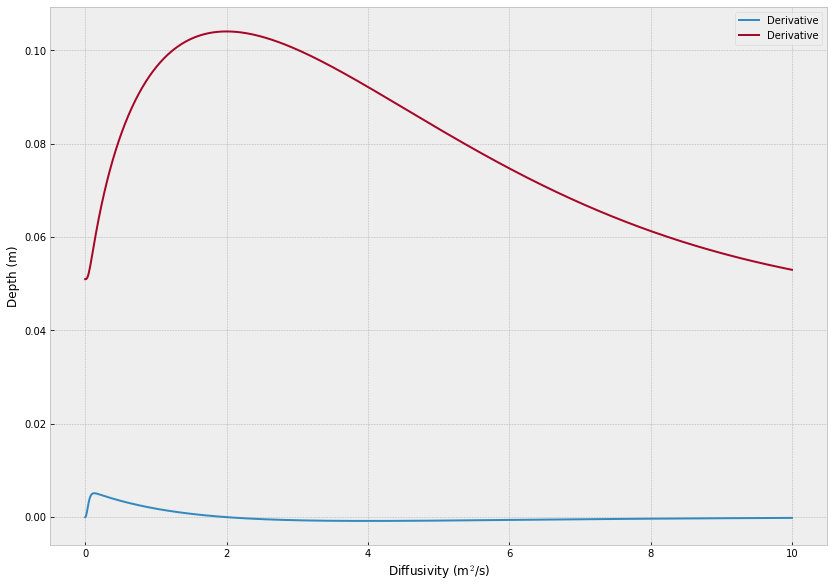

0.0
0.0035046034743536356
0.0018195919791379007
0.0007085498291115218
0.0


In [37]:
z=np.linspace(0, 10,1000)
profile=Diffu(z)
derivative=dKdz(z)
profile3=np.sqrt(2*profile)
profile4=dAdz(z)
Constant=z.copy()
Constant.fill(3e-3)

plt.figure(figsize=(11.69,8.27))
plt.plot(z, derivative,  label="Derivative")
plt.plot(z, profile3,  label="Derivative")

#plt.gca().invert_yaxis()
plt.xlabel("Diffusivity (m$^2$/s)")
plt.ylabel("Depth (m)")
plt.tight_layout()
plt.legend()
plt.savefig("Diffusivity.png")
plt.show()
print(dKdz(0))
print(dKdz(0.5))
print(dKdz(1))
print(dKdz(1.5))
print(dKdz(2))

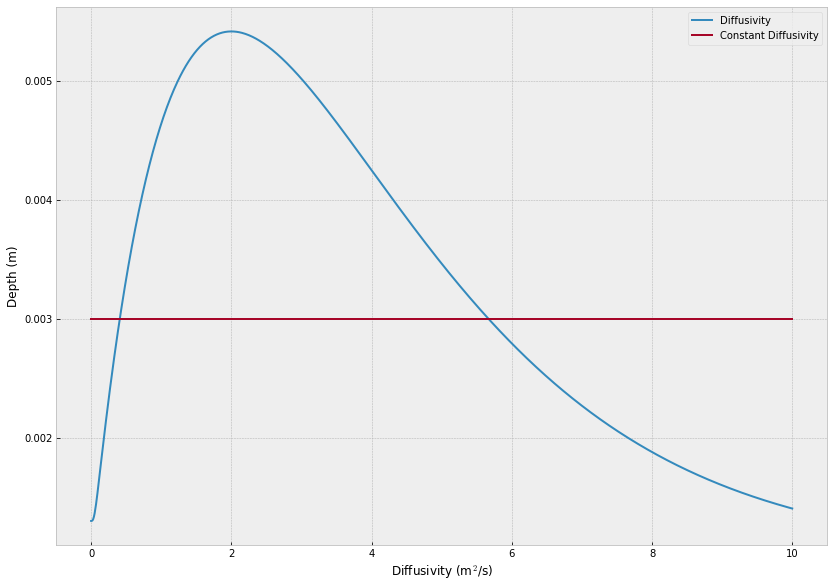

0.05099019513592785


In [38]:
z=np.linspace(0, 10,1000)
profile=Diffu(z)
derivative=dKdz(z)
profile3=np.sqrt(2*profile)

Constant=z.copy()
Constant.fill(3e-3)

plt.figure(figsize=(11.69,8.27))
#plt.plot(z, profile, label="Diffusion")
plt.plot(z, profile, label="Diffusivity")
#plt.plot(z, derivative,  label="Derivative")
plt.plot(z, np.full(1000, 3e-3),  label="Constant Diffusivity")
#plt.gca().invert_yaxis()
plt.xlabel("Diffusivity (m$^2$/s)")
plt.ylabel("Depth (m)")
plt.tight_layout()
plt.legend()
plt.savefig("Diffusivity.png")
plt.show()

print(np.sqrt(2*Diffu(0)))

### Testing and finding the anormaly for Euler scheme

In [ ]:
H =10
x =0.2 #setting it to zero will make it disappears.
upperBound =H*x
lowerBound =H-H*x

T_Max   = 2
dt      = 1        #Delta time
rFactor = 2        #reduceFactor
Np      = 200000
binDepth= 4
Nbins   = 200
counter = 0

hist_E_timeAdap     =np.zeros((Nbins-1,),'i')
hist_EConst_timeAdap =np.zeros((Nbins-1,),'i')

zEulTimeAdaptive =np.random.uniform(0,H,int(Np))
zEulConTimeAdaptive =np.random.uniform(0,H,int(Np))

hist_body=0
hist_edge=0

loop=int(T_Max/dt)
for i in range(loop):
    
    ###Euler-Maruyama
    maskBody=((upperBound<zEulTimeAdaptive)&(lowerBound>zEulTimeAdaptive))
    
    zEBody=zEulTimeAdaptive[maskBody]
    zEBody=step_e(zEBody, H, dt, zEBody.size)
    
    temp, _ = np.histogram(zEBody, bins = np.linspace(0, binDepth, Nbins))
    hist_body+=temp
    
    zEEdge = zEulTimeAdaptive[~maskBody]
    #zEEdge=step_e_Test1(zEEdge,H,dt,zEEdge.size)
    
    for j in range(rFactor):
        zEEdge=step_e(zEEdge,H,dt/rFactor,zEEdge.size)
        #zEEdge=step_e_Test2(zEEdge,H,dt/rFactor,zEEdge.size)
        
    temp, _ = np.histogram(zEEdge, bins = np.linspace(0, binDepth, Nbins))
    hist_edge+=temp
    
    zEulTimeAdaptive[maskBody]=zEBody
    zEulTimeAdaptive[~maskBody]=zEEdge
        
    temp0, _ = np.histogram(zEulTimeAdaptive, bins = np.linspace(0, binDepth, Nbins))
    hist_E_timeAdap=temp0+hist_E_timeAdap
    
    if (loop>100 and (i % int(loop/100) ==0)): # Printing process
        print("\r %6.2f"% (i*100/loop+1),"%", end="\r",flush=True)
    
    counter=counter+1

hist_E_timeAdap  = hist_E_timeAdap  /np.mean(hist_E_timeAdap)
hist_body = hist_body/counter
hist_edge = hist_edge/counter

In [ ]:
bins = np.linspace(0, binDepth, Nbins)
midpoints = bins[: -1] + (bins[1] - bins[0]) / 2

fig, ax = plt.subplots(ncols = 4, figsize = (11.69, 8.27))

ax[0].plot(hist_body, midpoints, lw = 1.5)
ax[0].invert_yaxis()

ax[1].plot(hist_edge, midpoints, lw = 1.5)
ax[1].invert_yaxis()

ax[2].plot(hist_body + hist_edge, midpoints, lw = 1.5)
#ax[2].set_xlim(390, 410)
ax[2].invert_yaxis()

ax[3].plot(hist_E_timeAdap, midpoints, lw = 1.5)
ax[3].invert_yaxis()

fig.subplots_adjust(hspace=0)
#plt.setp([ax[a].get_yticklabels() for a in range(1,4)], visible=False) 

fig.text(0.05, 0.35, "Depth: {:.1f}".format(binDepth), fontsize = 20)
fig.text(0.05, 0.30, "Bins: {:d}".format(Nbins), fontsize = 20)
fig.text(0.05, 0.25, "T_Max: {:d}".format(T_Max), fontsize = 20)
fig.text(0.05, 0.20, "dt: {:.1f}".format(dt), fontsize = 20)
fig.text(0.05, 0.15, "Factor: {:.2f}".format(rFactor), fontsize = 20)
fig.text(0.05, 0.10, "UpEdge: {:.2f}".format(upperBound), fontsize = 20)
fig.text(0.05, 0.05, "Par: {:d}".format(Np), fontsize = 20)

plt.tight_layout()
#plt.savefig(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))

In [ ]:
x = np.linspace(norm.ppf(0.0001),
                norm.ppf(0.9999), 100)
plt.plot(x, norm.pdf(x, 0, np.sqrt(1/10)),
       'r-', lw=1, alpha=0.6, label='norm pdf')

print(norm.ppf(0.01, 0, np.sqrt(1/10)))
print(norm.ppf(0.99, 0, np.sqrt(1/10)))

### Junk code below, Just for saving or testing

In [ ]:
bins = np.linspace(0, Testdepth, Nbins)
midpoints = bins[:-1] + (bins[1]-bins[0]) / 2

fig, ax = plt.subplots(ncols = 1, figsize = (11.69,8.27), sharey = True, sharex = True)


ax.plot(hist_V_timeAdap, midpoints, linewidth=1.5, label= "Visser")
ax.plot(hist_VConst_timeAdap, midpoints, linewidth=1.5, label= "Visser_const")
ax.set_xlabel('Concetration')
ax.set_title('Visser')
ax.set_xlim(0.959, 1.109)

ax.invert_yaxis()
plt.legend()
plt.tight_layout()
plt.savefig("wired1.png")

In [ ]:
start_time = time()

#Define the edge
x=0.05
upperBound=H*x
lowerBound=H-H*x

Tmax=12*3600     #Maximum time
dt=1             #Delta time
Ntime=int(Tmax/dt)  #Number of time interval
Np=20000          #Number of particles

rFactor=2   #reduceFactor
t_v=np.zeros(Np, dtype=float)

counter=0
hist_V_timeAdap=np.zeros((Nbins-1,),'i')

while np.any(t_v<Tmax): #comparing float may cause data error
    maskNotFinish=(t_v<Tmax)
    z_v_Notfinish=z_v_TimeAdaptive[maskNotFinish]
    t_v_Notfinish=t_v[maskNotFinish]
    
    maskBody=((upperBound<z_v_Notfinish)&(lowerBound>z_v_Notfinish))
    
    zVBody=z_v_Notfinish[maskBody]
    tBody=t_v_Notfinish[maskBody]
    
    zVEdge=z_v_Notfinish[~maskBody]
    tEdge=t_v_Notfinish[~maskBody]
    
    dtBody=np.minimum(dt, Tmax-tBody)
    dtEdge=np.minimum(dt/rFactor, Tmax-tEdge)
    
    zVBody=step_v(zVBody,H,dtBody,zVBody.size)
    t_v_Notfinish[maskBody]+=dtBody
    z_v_Notfinish[maskBody]=zVBody
    
    zVEdge=step_v(zVEdge,H,dtEdge,zVEdge.size)
    t_v_Notfinish[~maskBody]+=dtEdge
    z_v_Notfinish[~maskBody]=zVEdge
    
    t_v[maskNotFinish]=t_v_Notfinish
    z_v_TimeAdaptive[maskNotFinish]=z_v_Notfinish

    temp, _ = np.histogram(z_v_TimeAdaptive, bins = np.linspace(0, Testdepth, Nbins))
    hist_V_timeAdap=hist_V_timeAdap+temp
    counter=counter+1

hist_V_timeAdap=hist_V_timeAdap/counter

print("Time elapsed:",time()-start_time)

In [ ]:
def parallelBodyEdge(Tmax, dt, Testdepth, Np, Nbins,
                     queneEu, queneEuConst, queneV, queneVConst, queneM, queneM2, queneM2Const):
    np.random.seed()
    #Define the edge
    H =10
    x =0.02 #setting it to zero will make it disappears.
    upperBound =H*x
    lowerBound =H-H*x

    Ntime   =int(Tmax/dt)  #Number of time interval
    rFactor =10   #reduceFactor

    hist_E_timeAdap     =np.zeros((Nbins-1,),'i')
    hist_V_timeAdap     =np.zeros((Nbins-1,),'i')
    hist_M_timeAdap     =np.zeros((Nbins-1,),'i')
    hist_M2_timeAdap    =np.zeros((Nbins-1,),'i')

    hist_EConst_timeAdap =np.zeros((Nbins-1,),'i')
    hist_VConst_timeAdap =np.zeros((Nbins-1,),'i')
    hist_MConst_timeAdap =np.zeros((Nbins-1,),'i')

    zEulTimeAdaptive  =np.random.uniform(0,H,int(Np))
    zVisTimeAdaptive  =np.random.uniform(0,H,int(Np))
    zMilTimeAdaptive  =np.random.uniform(0,H,int(Np))
    zMil2TimeAdaptive =np.random.uniform(0,H,int(Np))

    zEulConTimeAdaptive =np.random.uniform(0,H,int(Np))
    zVisConTimeAdaptive =np.random.uniform(0,H,int(Np))
    zMilConTimeAdaptive =np.random.uniform(0,H,int(Np))


    for i in range(Ntime):

        ###Defining Mask
        maskBodyEul   =((upperBound<zEulTimeAdaptive)   &(lowerBound>zEulTimeAdaptive))
        maskBodyVis   =((upperBound<zVisTimeAdaptive)   &(lowerBound>zVisTimeAdaptive))
        maskBodyMil   =((upperBound<zMilTimeAdaptive)   &(lowerBound>zMilTimeAdaptive))
        maskBodyMil2  =((upperBound<zMil2TimeAdaptive)  &(lowerBound>zMil2TimeAdaptive))
        maskBodyEulCon=((upperBound<zEulConTimeAdaptive)&(lowerBound>zEulConTimeAdaptive))
        maskBodyVisCon=((upperBound<zVisConTimeAdaptive)&(lowerBound>zVisConTimeAdaptive))
        maskBodyMilCon=((upperBound<zMilConTimeAdaptive)&(lowerBound>zMilConTimeAdaptive))
        ###Defining Body
        zEBody   =zEulTimeAdaptive[maskBodyEul]
        zVBody   =zVisTimeAdaptive[maskBodyVis]
        zMBody   =zMilTimeAdaptive[maskBodyMil]
        zM2Body  =zMil2TimeAdaptive[maskBodyMil2]
        zEConBody=zEulConTimeAdaptive[maskBodyEulCon]
        zVConBody=zVisConTimeAdaptive[maskBodyVisCon]
        zMConBody=zMilConTimeAdaptive[maskBodyMilCon]
        ###Defining Edge
        zEEdge   =zEulTimeAdaptive[~maskBodyEul]
        zVEdge   =zVisTimeAdaptive[~maskBodyVis]
        zMEdge   =zMilTimeAdaptive[~maskBodyMil]
        zM2Edge  =zMil2TimeAdaptive[~maskBodyMil2]
        zEConEdge=zEulConTimeAdaptive[~maskBodyEulCon]
        zVConEdge=zVisConTimeAdaptive[~maskBodyVisCon]
        zMConEdge=zMilConTimeAdaptive[~maskBodyMilCon]
        
        zEBody   =step_e(zEBody, H, dt, zEBody.size)
        zVBody   =step_v(zVBody, H, dt, zVBody.size)
        zMBody   =step_m(zMBody, H, dt, zMBody.size)
        zM2Body  =step_m2(zM2Body, H, dt, zM2Body.size)
        zEConBody=step_e_const(zEConBody, H, dt, zEConBody.size)
        zVConBody=step_v_const(zVConBody, H, dt, zVConBody.size)
        zMConBody=step_m2_const(zMConBody,H,dt,zMConBody.size)
        
        for j in range(rFactor):
            zEEdge   =step_e(zEEdge, H, dt/rFactor, zEEdge.size)
            zVEdge   =step_v(zVEdge, H, dt/rFactor, zVEdge.size)
            zMEdge   =step_m(zMEdge, H, dt/rFactor, zMEdge.size)
            zM2Edge  =step_m2(zM2Edge, H, dt/rFactor, zM2Edge.size)
            zEConEdge=step_e_const(zEConEdge,H,dt/rFactor,zEConEdge.size)
            zVConEdge=step_v_const(zVConEdge,H,dt/rFactor,zVConEdge.size)
            zMConEdge=step_m2_const(zMConEdge,H,dt/rFactor,zMConEdge.size)

        zEulTimeAdaptive[maskBodyEul]       =zEBody
        zVisTimeAdaptive[maskBodyVis]       =zVBody
        zMilTimeAdaptive[maskBodyMil]       =zMBody
        zMil2TimeAdaptive[maskBodyMil2]     =zM2Body
        zEulConTimeAdaptive[maskBodyEulCon] =zEConBody
        zVisConTimeAdaptive[maskBodyVisCon] =zVConBody
        zMilConTimeAdaptive[maskBodyMilCon] =zMConBody
        
        zEulTimeAdaptive[~maskBodyEul]       =zEEdge
        zVisTimeAdaptive[~maskBodyVis]       =zVEdge
        zMilTimeAdaptive[~maskBodyMil]       =zMEdge
        zMil2TimeAdaptive[~maskBodyMil2]     =zM2Edge
        zEulConTimeAdaptive[~maskBodyEulCon] =zEConEdge
        zVisConTimeAdaptive[~maskBodyVisCon] =zVConEdge
        zMilConTimeAdaptive[~maskBodyMilCon] =zMConEdge
    

        #Adding the histogram
        ###
        temp0, _ = np.histogram(zEulTimeAdaptive, bins = np.linspace(0, Testdepth, Nbins))
        hist_E_timeAdap=hist_E_timeAdap+temp0

        temp1, _ = np.histogram(zVisTimeAdaptive, bins = np.linspace(0, Testdepth, Nbins))
        hist_V_timeAdap=hist_V_timeAdap+temp1

        temp2, _ = np.histogram(zMilTimeAdaptive, bins = np.linspace(0, Testdepth, Nbins))
        hist_M_timeAdap=hist_M_timeAdap+temp2

        temp3, _ = np.histogram(zMil2TimeAdaptive, bins = np.linspace(0, Testdepth, Nbins))
        hist_M2_timeAdap=hist_M2_timeAdap+temp3

        ### Constant potensial
        temp4, _ = np.histogram(zEulConTimeAdaptive, bins = np.linspace(0, Testdepth, Nbins))
        hist_EConst_timeAdap=hist_EConst_timeAdap+temp4

        temp5, _ = np.histogram(zVisConTimeAdaptive, bins = np.linspace(0, Testdepth, Nbins))
        hist_VConst_timeAdap=hist_VConst_timeAdap+temp5

        temp6, _ = np.histogram(zMilConTimeAdaptive, bins = np.linspace(0, Testdepth, Nbins))
        hist_MConst_timeAdap=hist_MConst_timeAdap+temp6

        if (i % int(Ntime/100) ==0):
            print("\r %6.2f"% (i*100/Ntime+1),"%", end="\r",flush=True)
            
    queneEu.put(hist_E_timeAdap)
    queneEuConst.put(hist_EConst_timeAdap)
    queneV.put(hist_V_timeAdap)
    queneVConst.put(hist_VConst_timeAdap)
    queneM.put(hist_M_timeAdap)
    queneM2.put(hist_M2_timeAdap)
    queneM2Const.put(hist_MConst_timeAdap)
            
    return None
        
NumberOfThread = int(mp.cpu_count()/2)
print("NumberOfProcess: ", NumberOfThread)
Np        = 20000
Nbins     = 200
SubNp     = np.full((NumberOfThread,), int(Np/NumberOfThread))
SubNp[-1] = SubNp[-1] + (Np%NumberOfThread)                 

Tmax      = 12*3600       #Maximum time
dt        = 1             #Delta time
Ntime     = int(Tmax/dt)  #Number of time interval
Testdepth = 0.5
timer=time()
counter=Ntime

if (__name__ == '__main__'):
    threads=[]
    queneEu=      mp.Queue()
    queneEuConst= mp.Queue()
    queneV=       mp.Queue()
    queneVConst=  mp.Queue()
    queneM=       mp.Queue()
    queneM2=      mp.Queue()
    queneM2Const= mp.Queue()
    
    for i in range(NumberOfThread):
        thread = mp.Process(target= parallelBodyEdge, 
                            args= (Tmax, dt, Testdepth, SubNp[i], Nbins,
                                   queneEu, queneEuConst, queneV, queneVConst, queneM, queneM2, queneM2Const))
        threads.append(thread)
        thread.start()    #starting calculation.
    
    for thread in threads:  
        thread.join()     #waiting these processes finish. 

print("\n Time elapsed: ", time()-timer)
        
hist_E_timeAdap      = np.zeros((Nbins-1,),'i')
hist_EConst_timeAdap = np.zeros((Nbins-1,),'i')
hist_V_timeAdap      = np.zeros((Nbins-1,),'i')
hist_VConst_timeAdap = np.zeros((Nbins-1,),'i')
hist_M_timeAdap      = np.zeros((Nbins-1,),'i')
hist_M2_timeAdap     = np.zeros((Nbins-1,),'i')
hist_MConst_timeAdap = np.zeros((Nbins-1,),'i')

for i in range(NumberOfThread):
    hist_E_timeAdap      += queneEu.get()
    hist_EConst_timeAdap += queneEuConst.get()
    hist_V_timeAdap      += queneV.get()
    hist_VConst_timeAdap += queneVConst.get()
    hist_M_timeAdap      += queneM.get()
    hist_M2_timeAdap     += queneM2.get()
    hist_MConst_timeAdap += queneM2Const.get()

hist_E_timeAdap  =hist_E_timeAdap  /counter
hist_V_timeAdap  =hist_V_timeAdap  /counter
hist_M_timeAdap  =hist_M_timeAdap  /counter
hist_M2_timeAdap =hist_M2_timeAdap /counter

hist_EConst_timeAdap  =hist_EConst_timeAdap  /counter
hist_VConst_timeAdap  =hist_VConst_timeAdap  /counter
hist_MConst_timeAdap  =hist_MConst_timeAdap  /counter

hist_E_timeAdap  =hist_E_timeAdap  /np.mean(hist_E_timeAdap)
hist_V_timeAdap  =hist_V_timeAdap  /np.mean(hist_V_timeAdap)
hist_M_timeAdap  =hist_M_timeAdap  /np.mean(hist_M_timeAdap)
hist_M2_timeAdap =hist_M2_timeAdap /np.mean(hist_M2_timeAdap)

hist_EConst_timeAdap  =hist_EConst_timeAdap  /np.mean(hist_EConst_timeAdap)
hist_VConst_timeAdap  =hist_VConst_timeAdap  /np.mean(hist_VConst_timeAdap)
hist_MConst_timeAdap  =hist_MConst_timeAdap  /np.mean(hist_MConst_timeAdap)


In [ ]:
NumberOfThread = int(mp.cpu_count()/2)
print("NumberOfProcess: ", NumberOfThread)
Np        = 20000
Nbins     = 200
SubNp     = np.full((NumberOfThread,), int(Np/NumberOfThread))
SubNp[-1] = SubNp[-1] + (Np%NumberOfThread)                 

Tmax      = 12*3600       #Maximum time
dt        = 1             #Delta time
H         = 10
prosent   = 0.02
rFactor   = 10
Ntime     = int(Tmax/dt)  #Number of time interval
Testdepth = 0.5
timer=time()
counter=Ntime

if (__name__ == '__main__'):
    threads=[]
    queneEu=      mp.Queue()
    queneEuConst= mp.Queue()
    queneV=       mp.Queue()
    queneVConst=  mp.Queue()
    queneM=       mp.Queue()
    queneM2=      mp.Queue()
    queneM2Const= mp.Queue()
    
    for i in range(NumberOfThread):
        thread = mp.Process(target= parallelBodyEdge, 
                            args= (Tmax, dt, H, prosent, rFactor, Testdepth, SubNp[i], Nbins,
                                   queneEu, queneEuConst, queneV, queneVConst, queneM, queneM2, queneM2Const))
        threads.append(thread)
        thread.start()    #starting calculation.
    
    for thread in threads:  
        thread.join()     #waiting these processes finish. 

print("\n Time elapsed: ", time()-timer)
        
hist_E_timeAdap      = np.zeros((Nbins-1,),'i')
hist_EConst_timeAdap = np.zeros((Nbins-1,),'i')
hist_V_timeAdap      = np.zeros((Nbins-1,),'i')
hist_VConst_timeAdap = np.zeros((Nbins-1,),'i')
hist_M_timeAdap      = np.zeros((Nbins-1,),'i')
hist_M2_timeAdap     = np.zeros((Nbins-1,),'i')
hist_MConst_timeAdap = np.zeros((Nbins-1,),'i')

for i in range(NumberOfThread):
    hist_E_timeAdap      += queneEu.get()
    hist_EConst_timeAdap += queneEuConst.get()
    hist_V_timeAdap      += queneV.get()
    hist_VConst_timeAdap += queneVConst.get()
    hist_M_timeAdap      += queneM.get()
    hist_M2_timeAdap     += queneM2.get()
    hist_MConst_timeAdap += queneM2Const.get()

hist_E_timeAdap  =hist_E_timeAdap  /counter
hist_V_timeAdap  =hist_V_timeAdap  /counter
hist_M_timeAdap  =hist_M_timeAdap  /counter
hist_M2_timeAdap =hist_M2_timeAdap /counter
hist_EConst_timeAdap  =hist_EConst_timeAdap  /counter
hist_VConst_timeAdap  =hist_VConst_timeAdap  /counter
hist_MConst_timeAdap  =hist_MConst_timeAdap  /counter

hist_E_timeAdap  =hist_E_timeAdap  /np.mean(hist_E_timeAdap)
hist_V_timeAdap  =hist_V_timeAdap  /np.mean(hist_V_timeAdap)
hist_M_timeAdap  =hist_M_timeAdap  /np.mean(hist_M_timeAdap)
hist_M2_timeAdap =hist_M2_timeAdap /np.mean(hist_M2_timeAdap)
hist_EConst_timeAdap  =hist_EConst_timeAdap  /np.mean(hist_EConst_timeAdap)
hist_VConst_timeAdap  =hist_VConst_timeAdap  /np.mean(hist_VConst_timeAdap)
hist_MConst_timeAdap  =hist_MConst_timeAdap  /np.mean(hist_MConst_timeAdap)


In [ ]:
bins = np.linspace(0, Testdepth, Nbins)
midpoints = bins[:-1] + (bins[1]-bins[0]) / 2

fig, ax = plt.subplots(ncols = 4, figsize = (18, 8), sharey = True, sharex = True)

ax[0].plot(hist_E_timeAdap, midpoints, linewidth=1.5, label= "Visser")
ax[0].plot(hist_EConst_timeAdap, midpoints, linewidth=1.5, label= "Visser_const")
ax[0].set_xlabel('Concetration')
ax[0].set_ylabel('Depth /m')
ax[0].set_title('Euler-Maruyama')
ax[0].invert_yaxis()

ax[1].plot(hist_V_timeAdap, midpoints, linewidth=1.5, label= "Visser")
ax[1].plot(hist_VConst_timeAdap, midpoints, linewidth=1.5, label= "Visser_const")
ax[1].set_xlabel('Concetration')
ax[1].set_title('Visser')

ax[2].plot(hist_M_timeAdap, midpoints, linewidth=1.5, label= "Visser")
ax[2].plot(hist_MConst_timeAdap, midpoints, linewidth=1.5, label= "Visser_const")
ax[2].set_xlabel('Concetration')
ax[2].set_title('Milstein 1 st')

ax[3].plot(hist_M2_timeAdap, midpoints, linewidth=1.5, label= "Milstein_2")
ax[3].plot(hist_MConst_timeAdap, midpoints, linewidth=1.5, label= "Milstein_2_const")
ax[3].set_xlabel('Concetration')
ax[3].set_title('Milstein 2 nd')

plt.tight_layout()

In [ ]:
def parallel(Np, Nbins, Testdepth, hist_M2, hist_M2_Const, hist_m, hist_V, hist_V_Const):
    Tmax=12*3600     #Maximum time
    dt=1             #Delta time
    Ntime=int(Tmax/dt)  #Number of time interval
    
    z_m2=np.random.uniform(0,10,int(Np))
    z_m2_Const=z_m2.copy()
    z_v=z_m2.copy()   
    z_v_const=z_m2.copy()
    z_m=z_m2.copy()

    H=10
    Nregi=10
    Gap=int(Ntime/Nregi)
    Gap=1           #Set to 1 if you want histogram to recorde all the timestep.
                    #Or comment it, then histogram will skip some timestep.


    for i in range(Ntime-1):
        z_v=step_v(z_v,H,dt,Np)
        z_v_const=step_v_const(z_v_const,H,dt,Np)
        z_m=step_m(z_m,H,dt,Np)
        z_m2=step_m2(z_m2,H,dt,Np)
        z_m2_Const=step_m2_const(z_m2_Const,H,dt,Np)

        if (i % int(Ntime/100) ==0):
            print("\r %6.2f"% (i*100/Ntime+1),"%", end="\r",flush=True)

        if ( i % Gap ==0):
            temp1, _ = np.histogram(z_v,             bins = np.linspace(0, Testdepth, Nbins))
            hist_V[:]=hist_V[:]+temp1

            temp2, _ = np.histogram(z_v_const,       bins = np.linspace(0, Testdepth, Nbins))
            hist_V_Const[:]=hist_V_Const[:]+temp2

            temp3, _ = np.histogram(z_m,             bins = np.linspace(0, Testdepth, Nbins))
            hist_M[:]=hist_M[:]+temp3

            temp4, _ = np.histogram(z_m2,            bins = np.linspace(0, Testdepth, Nbins))
            hist_M2[:]=hist_M2[:]+temp4

            temp5, _ = np.histogram(z_m2_Const,      bins = np.linspace(0, Testdepth, Nbins))
            hist_M2_Const[:]=hist_M2_Const[:]+temp5

    return None

NumberOfThread=8
Np=2000
Nbins=200
hist_M2=          np.zeros((NumberOfThread,Nbins-1),'i')
hist_M2_Const=    np.zeros((NumberOfThread,Nbins-1),'i')
hist_M=           np.zeros((NumberOfThread,Nbins-1),'i')
hist_V=           np.zeros((NumberOfThread,Nbins-1),'i')
hist_V_Const=     np.zeros((NumberOfThread,Nbins-1),'i')

Tmax=12*3600     #Maximum time
dt=1             #Delta time
Ntime=int(Tmax/dt)  #Number of time interval
Testdepth=0.5

if (Np%NumberOfThread==0):
    threads=[]
    SubNp=int(Np/NumberOfThread)
    
    timer=time()
    for i in range(NumberOfThread):
        thread = threading.Thread(target=parallel, args=(SubNp, Nbins, Testdepth,
                                                         hist_M2[i,:],hist_M2_Const[i,:],hist_M[i,:], 
                                                         hist_V[i,:], hist_V_Const[i,:]))
        threads.append(thread)
        thread.start()
    
    for thread in threads:  
        thread.join()
        
print("\n Time elapsed: ", time()-timer)

hist_V=          np.sum(hist_V,       axis=0)
hist_V_Const=    np.sum(hist_V_Const, axis=0)
hist_M=          np.sum(hist_M,       axis=0)
hist_M2=         np.sum(hist_M2,      axis=0)
hist_M2_Const=   np.sum(hist_M2_Const,axis=0)

hist_V=        hist_V/        Ntime
hist_V_Const=  hist_V_Const/  Ntime
hist_M=        hist_M/        Ntime
hist_M2=       hist_M2/       Ntime
hist_M2_Const= hist_M2_Const/ Ntime

hist_V=        hist_V/        np.mean(hist_V)
hist_V_Const=  hist_V_Const/  np.mean(hist_V_Const)
hist_M=        hist_M/        np.mean(hist_M)
hist_M2=       hist_M2/       np.mean(hist_M2)
hist_M2_Const= hist_M2_Const/ np.mean(hist_M2_Const)

In [ ]:
def parallelBodyEdge(Tmax, dt, Testdepth, Np, Nbins,
                     queneEu, queneEuConst, queneV, queneVConst, queneM, queneM2, queneM2Const):
    np.random.seed()
    #Define the edge
    H =10
    x =0.02 #setting it to zero will make it disappears.
    upperBound =H*x
    lowerBound =H-H*x

    Ntime   =int(Tmax/dt)  #Number of time interval
    rFactor =10   #reduceFactor

    hist_E_timeAdap     =np.zeros((Nbins-1,),'i')
    hist_V_timeAdap     =np.zeros((Nbins-1,),'i')
    hist_M_timeAdap     =np.zeros((Nbins-1,),'i')
    hist_M2_timeAdap    =np.zeros((Nbins-1,),'i')

    hist_EConst_timeAdap =np.zeros((Nbins-1,),'i')
    hist_VConst_timeAdap =np.zeros((Nbins-1,),'i')
    hist_MConst_timeAdap =np.zeros((Nbins-1,),'i')

    zEulTimeAdaptive  =np.random.uniform(0,H,int(Np))
    zVisTimeAdaptive  =np.random.uniform(0,H,int(Np))
    zMilTimeAdaptive  =np.random.uniform(0,H,int(Np))
    zMil2TimeAdaptive =np.random.uniform(0,H,int(Np))

    zEulConTimeAdaptive =np.random.uniform(0,H,int(Np))
    zVisConTimeAdaptive =np.random.uniform(0,H,int(Np))
    zMilConTimeAdaptive =np.random.uniform(0,H,int(Np))


    for i in range(Ntime):

        ###Euler-Maruyama
        maskBody=((upperBound<zEulTimeAdaptive)&(lowerBound>zEulTimeAdaptive))

        zEBody=zEulTimeAdaptive[maskBody]
        zEBody=step_e(zEBody, H, dt, zEBody.size)

        zEEdge=zEulTimeAdaptive[~maskBody]
        for j in range(rFactor):
            zEEdge=step_e(zEEdge,H,dt/rFactor,zEEdge.size)

        zEulTimeAdaptive[maskBody]=zEBody
        zEulTimeAdaptive[~maskBody]=zEEdge


        ###Viser
        maskBody=((upperBound<zVisTimeAdaptive)&(lowerBound>zVisTimeAdaptive))

        zVBody=zVisTimeAdaptive[maskBody]
        zVBody=step_v(zVBody, H, dt, zVBody.size)

        zVEdge=zVisTimeAdaptive[~maskBody]
        for j in range(rFactor):
            zVEdge=step_v(zVEdge,H,dt/rFactor,zVEdge.size)

        zVisTimeAdaptive[maskBody]=zVBody
        zVisTimeAdaptive[~maskBody]=zVEdge


        ###Milstein
        maskBody=((upperBound<zMilTimeAdaptive)&(lowerBound>zMilTimeAdaptive))

        zMBody=zMilTimeAdaptive[maskBody]
        zMBody=step_m(zMBody,H,dt,zMBody.size)

        zMEdge=zMilTimeAdaptive[~maskBody]
        for j in range(rFactor):
            zMEdge=step_m(zMEdge,H,dt/rFactor,zMEdge.size)

        zMilTimeAdaptive[maskBody]=zMBody
        zMilTimeAdaptive[~maskBody]=zMEdge


        ###Milstein 2
        maskBody=((upperBound<zMil2TimeAdaptive)&(lowerBound>zMil2TimeAdaptive))

        zM2Body=zMil2TimeAdaptive[maskBody]
        zM2Body=step_m2(zM2Body,H,dt,zM2Body.size)

        zM2Edge=zMil2TimeAdaptive[~maskBody]
        for j in range(rFactor):
            zM2Edge=step_m2(zM2Edge,H,dt/rFactor,zM2Edge.size)

        zMil2TimeAdaptive[maskBody]=zM2Body
        zMil2TimeAdaptive[~maskBody]=zM2Edge

        ###Constant Potential

        ###Euler-Maruyama-Constant
        maskBody=((upperBound<zEulConTimeAdaptive)&(lowerBound>zEulConTimeAdaptive))

        zEBody=zEulConTimeAdaptive[maskBody]
        zEBody=step_e_const(zEBody, H, dt, zEBody.size)

        zEEdge=zEulConTimeAdaptive[~maskBody]
        for j in range(rFactor):
            zEEdge=step_e_const(zEEdge,H,dt/rFactor,zEEdge.size)

        zEulConTimeAdaptive[maskBody]=zEBody
        zEulConTimeAdaptive[~maskBody]=zEEdge

        ###Viser-Constant
        maskBody=((upperBound<zVisConTimeAdaptive)&(lowerBound>zVisConTimeAdaptive))

        zVBody=zVisConTimeAdaptive[maskBody]
        zVBody=step_v_const(zVBody, H, dt, zVBody.size)

        zVEdge=zVisConTimeAdaptive[~maskBody]
        for j in range(rFactor):
            zVEdge=step_v_const(zVEdge,H,dt/rFactor,zVEdge.size)

        zVisConTimeAdaptive[maskBody]=zVBody
        zVisConTimeAdaptive[~maskBody]=zVEdge

        ###Milstein-Constant 
        maskBody=((upperBound<zMilConTimeAdaptive)&(lowerBound>zMilConTimeAdaptive))

        zMBody=zMilConTimeAdaptive[maskBody]
        zMBody=step_m2_const(zMBody,H,dt,zMBody.size)

        zMEdge=zMilConTimeAdaptive[~maskBody]
        for j in range(rFactor):
            zMEdge=step_m2_const(zMEdge,H,dt/rFactor,zMEdge.size)

        zMilConTimeAdaptive[maskBody]=zMBody
        zMilConTimeAdaptive[~maskBody]=zMEdge

        #Adding the histogram
        ###
        temp0, _ = np.histogram(zEulTimeAdaptive, bins = np.linspace(0, Testdepth, Nbins))
        hist_E_timeAdap=hist_E_timeAdap+temp0

        temp1, _ = np.histogram(zVisTimeAdaptive, bins = np.linspace(0, Testdepth, Nbins))
        hist_V_timeAdap=hist_V_timeAdap+temp1

        temp2, _ = np.histogram(zMilTimeAdaptive, bins = np.linspace(0, Testdepth, Nbins))
        hist_M_timeAdap=hist_M_timeAdap+temp2

        temp3, _ = np.histogram(zMil2TimeAdaptive, bins = np.linspace(0, Testdepth, Nbins))
        hist_M2_timeAdap=hist_M2_timeAdap+temp3

        ### Constant potensial
        temp4, _ = np.histogram(zEulConTimeAdaptive, bins = np.linspace(0, Testdepth, Nbins))
        hist_EConst_timeAdap=hist_EConst_timeAdap+temp4

        temp5, _ = np.histogram(zVisConTimeAdaptive, bins = np.linspace(0, Testdepth, Nbins))
        hist_VConst_timeAdap=hist_VConst_timeAdap+temp5

        temp6, _ = np.histogram(zMilConTimeAdaptive, bins = np.linspace(0, Testdepth, Nbins))
        hist_MConst_timeAdap=hist_MConst_timeAdap+temp6

        if (i % int(Ntime/100) ==0):
            print("\r %6.2f"% (i*100/Ntime+1),"%", end="\r",flush=True)
            
    queneEu.put(hist_E_timeAdap)
    queneEuConst.put(hist_EConst_timeAdap)
    queneV.put(hist_V_timeAdap)
    queneVConst.put(hist_VConst_timeAdap)
    queneM.put(hist_M_timeAdap)
    queneM2.put(hist_M2_timeAdap)
    queneM2Const.put(hist_MConst_timeAdap)
            
    return None
        
NumberOfThread = int(mp.cpu_count()/2)
print("NumberOfProcess: ", NumberOfThread)
Np        = 20000
Nbins     = 200
SubNp     = np.full((NumberOfThread,), int(Np/NumberOfThread))
SubNp[-1] = SubNp[-1] + (Np%NumberOfThread)                 

Tmax      = 12*3600       #Maximum time
dt        = 1             #Delta time
Ntime     = int(Tmax/dt)  #Number of time interval
Testdepth = 0.5
timer=time()
counter=Ntime

if (__name__ == '__main__'):
    threads=[]
    queneEu=      mp.Queue()
    queneEuConst= mp.Queue()
    queneV=       mp.Queue()
    queneVConst=  mp.Queue()
    queneM=       mp.Queue()
    queneM2=      mp.Queue()
    queneM2Const= mp.Queue()
    
    for i in range(NumberOfThread):
        thread = mp.Process(target= parallelBodyEdge, 
                            args= (Tmax, dt, Testdepth, SubNp[i], Nbins,
                                   queneEu, queneEuConst, queneV, queneVConst, queneM, queneM2, queneM2Const))
        threads.append(thread)
        thread.start()    #starting calculation.
    
    for thread in threads:  
        thread.join()     #waiting these processes finish. 

print("\n Time elapsed: ", time()-timer)
        
hist_E_timeAdap      = np.zeros((Nbins-1,),'i')
hist_EConst_timeAdap = np.zeros((Nbins-1,),'i')
hist_V_timeAdap      = np.zeros((Nbins-1,),'i')
hist_VConst_timeAdap = np.zeros((Nbins-1,),'i')
hist_M_timeAdap      = np.zeros((Nbins-1,),'i')
hist_M2_timeAdap     = np.zeros((Nbins-1,),'i')
hist_MConst_timeAdap = np.zeros((Nbins-1,),'i')

for i in range(NumberOfThread):
    hist_E_timeAdap      += queneEu.get()
    hist_EConst_timeAdap += queneEuConst.get()
    hist_V_timeAdap      += queneV.get()
    hist_VConst_timeAdap += queneVConst.get()
    hist_M_timeAdap      += queneM.get()
    hist_M2_timeAdap     += queneM2.get()
    hist_MConst_timeAdap += queneM2Const.get()

hist_E_timeAdap  =hist_E_timeAdap  /counter
hist_V_timeAdap  =hist_V_timeAdap  /counter
hist_M_timeAdap  =hist_M_timeAdap  /counter
hist_M2_timeAdap =hist_M2_timeAdap /counter

hist_EConst_timeAdap  =hist_EConst_timeAdap  /counter
hist_VConst_timeAdap  =hist_VConst_timeAdap  /counter
hist_MConst_timeAdap  =hist_MConst_timeAdap  /counter

hist_E_timeAdap  =hist_E_timeAdap  /np.mean(hist_E_timeAdap)
hist_V_timeAdap  =hist_V_timeAdap  /np.mean(hist_V_timeAdap)
hist_M_timeAdap  =hist_M_timeAdap  /np.mean(hist_M_timeAdap)
hist_M2_timeAdap =hist_M2_timeAdap /np.mean(hist_M2_timeAdap)

hist_EConst_timeAdap  =hist_EConst_timeAdap  /np.mean(hist_EConst_timeAdap)
hist_VConst_timeAdap  =hist_VConst_timeAdap  /np.mean(hist_VConst_timeAdap)
hist_MConst_timeAdap  =hist_MConst_timeAdap  /np.mean(hist_MConst_timeAdap)


In [ ]:
start_time = time()

#Define the edge
H =10
x =0.02 #setting it to zero will make it disappears.
upperBound =H*x
lowerBound =H-H*x

Tmax    =12*3600     #Maximum time
dt      =1.0             #Delta time
Ntime   =int(Tmax/dt)  #Number of time interval
Np      =20000
rFactor =10   #reduceFactor
t_v     =np.zeros(Np, dtype=float)
Nbins   =1000
counter =0

hist_E_timeAdap     =np.zeros((Nbins-1,),'i')
hist_V_timeAdap     =np.zeros((Nbins-1,),'i')
hist_M_timeAdap     =np.zeros((Nbins-1,),'i')
hist_M2_timeAdap    =np.zeros((Nbins-1,),'i')

hist_EConst_timeAdap =np.zeros((Nbins-1,),'i')
hist_VConst_timeAdap =np.zeros((Nbins-1,),'i')
hist_MConst_timeAdap =np.zeros((Nbins-1,),'i')

zEulTimeAdaptive =np.random.uniform(0,H,int(Np))
zVisTimeAdaptive =np.random.uniform(0,H,int(Np))
zMilTimeAdaptive =np.random.uniform(0,H,int(Np))
zMil2TimeAdaptive=np.random.uniform(0,H,int(Np))

zEulConTimeAdaptive =np.random.uniform(0,H,int(Np))
zVisConTimeAdaptive =np.random.uniform(0,H,int(Np))
zMilConTimeAdaptive =np.random.uniform(0,H,int(Np))


binDepth=H

for i in range(Ntime):
    
    ###Euler-Maruyama
    maskBody=((upperBound<zEulTimeAdaptive)&(lowerBound>zEulTimeAdaptive))
    
    zEBody=zEulTimeAdaptive[maskBody]
    zEBody=step_e(zEBody, H, dt, zEBody.size)
    
    zEEdge=zEulTimeAdaptive[~maskBody]
    for j in range(rFactor):
        zEEdge=step_e(zEEdge,H,dt/rFactor,zEEdge.size)
        
    zEulTimeAdaptive[maskBody]=zEBody
    zEulTimeAdaptive[~maskBody]=zEEdge
    
    
    ###Viser
    maskBody=((upperBound<zVisTimeAdaptive)&(lowerBound>zVisTimeAdaptive))
    
    zVBody=zVisTimeAdaptive[maskBody]
    zVBody=step_v(zVBody, H, dt, zVBody.size)
    
    zVEdge=zVisTimeAdaptive[~maskBody]
    for j in range(rFactor):
        zVEdge=step_v(zVEdge,H,dt/rFactor,zVEdge.size)
        
    zVisTimeAdaptive[maskBody]=zVBody
    zVisTimeAdaptive[~maskBody]=zVEdge
    
    
    ###Milstein
    maskBody=((upperBound<zMilTimeAdaptive)&(lowerBound>zMilTimeAdaptive))
    
    zMBody=zMilTimeAdaptive[maskBody]
    zMBody=step_m(zMBody,H,dt,zMBody.size)
    
    zMEdge=zMilTimeAdaptive[~maskBody]
    for j in range(rFactor):
        zMEdge=step_m(zMEdge,H,dt/rFactor,zMEdge.size)
        
    zMilTimeAdaptive[maskBody]=zMBody
    zMilTimeAdaptive[~maskBody]=zMEdge
    
    
    ###Milstein 2
    maskBody=((upperBound<zMil2TimeAdaptive)&(lowerBound>zMil2TimeAdaptive))
    
    zM2Body=zMil2TimeAdaptive[maskBody]
    zM2Body=step_m2(zM2Body,H,dt,zM2Body.size)
    
    zM2Edge=zMil2TimeAdaptive[~maskBody]
    for j in range(rFactor):
        zM2Edge=step_m2(zM2Edge,H,dt/rFactor,zM2Edge.size)
        
    zMil2TimeAdaptive[maskBody]=zM2Body
    zMil2TimeAdaptive[~maskBody]=zM2Edge
    
    ###Constant Potential
    
    ###Euler-Maruyama-Constant
    maskBody=((upperBound<zEulConTimeAdaptive)&(lowerBound>zEulConTimeAdaptive))
    
    zEBody=zEulConTimeAdaptive[maskBody]
    zEBody=step_e_const(zEBody, H, dt, zEBody.size)
    
    zEEdge=zEulConTimeAdaptive[~maskBody]
    for j in range(rFactor):
        zEEdge=step_e_const(zEEdge,H,dt/rFactor,zEEdge.size)
        
    zEulConTimeAdaptive[maskBody]=zEBody
    zEulConTimeAdaptive[~maskBody]=zEEdge
    
    ###Viser-Constant
    maskBody=((upperBound<zVisConTimeAdaptive)&(lowerBound>zVisConTimeAdaptive))
    
    zVBody=zVisConTimeAdaptive[maskBody]
    zVBody=step_v_const(zVBody, H, dt, zVBody.size)
    
    zVEdge=zVisConTimeAdaptive[~maskBody]
    for j in range(rFactor):
        zVEdge=step_v_const(zVEdge,H,dt/rFactor,zVEdge.size)
        
    zVisConTimeAdaptive[maskBody]=zVBody
    zVisConTimeAdaptive[~maskBody]=zVEdge
    
    ###Milstein-Constant 
    maskBody=((upperBound<zMilConTimeAdaptive)&(lowerBound>zMilConTimeAdaptive))
    
    zMBody=zMilConTimeAdaptive[maskBody]
    zMBody=step_m2_const(zMBody,H,dt,zMBody.size)
    
    zMEdge=zMilConTimeAdaptive[~maskBody]
    for j in range(rFactor):
        zMEdge=step_m2_const(zMEdge,H,dt/rFactor,zMEdge.size)
        
    zMilConTimeAdaptive[maskBody]=zMBody
    zMilConTimeAdaptive[~maskBody]=zMEdge
    
    #Adding the histogram
    ###
    temp0, _ = np.histogram(zEulTimeAdaptive, bins = np.linspace(0, binDepth, Nbins))
    hist_E_timeAdap=hist_E_timeAdap+temp0
    
    temp1, _ = np.histogram(zVisTimeAdaptive, bins = np.linspace(0, binDepth, Nbins))
    hist_V_timeAdap=hist_V_timeAdap+temp1
 
    temp2, _ = np.histogram(zMilTimeAdaptive, bins = np.linspace(0, binDepth, Nbins))
    hist_M_timeAdap=hist_M_timeAdap+temp2
    
    temp3, _ = np.histogram(zMil2TimeAdaptive, bins = np.linspace(0, binDepth, Nbins))
    hist_M2_timeAdap=hist_M2_timeAdap+temp3
    
    ### Constant potensial
    temp4, _ = np.histogram(zEulConTimeAdaptive, bins = np.linspace(0, binDepth, Nbins))
    hist_EConst_timeAdap=hist_EConst_timeAdap+temp4
    
    temp5, _ = np.histogram(zVisConTimeAdaptive, bins = np.linspace(0, binDepth, Nbins))
    hist_VConst_timeAdap=hist_VConst_timeAdap+temp5
 
    temp6, _ = np.histogram(zMilConTimeAdaptive, bins = np.linspace(0, binDepth, Nbins))
    hist_MConst_timeAdap=hist_MConst_timeAdap+temp6
    
    
    counter=counter+1
    
    if (i % int(Ntime/100) ==0):
        print("\r %6.2f"% (i*100/Ntime+1),"%", end="\r",flush=True)
hist_E_timeAdap  =hist_E_timeAdap  /counter
hist_V_timeAdap  =hist_V_timeAdap  /counter
hist_M_timeAdap  =hist_M_timeAdap  /counter
hist_M2_timeAdap =hist_M2_timeAdap /counter

hist_EConst_timeAdap  =hist_EConst_timeAdap  /counter
hist_VConst_timeAdap  =hist_VConst_timeAdap  /counter
hist_MConst_timeAdap  =hist_MConst_timeAdap  /counter

hist_E_timeAdap  =hist_E_timeAdap  /np.mean(hist_E_timeAdap)
hist_V_timeAdap  =hist_V_timeAdap  /np.mean(hist_V_timeAdap)
hist_M_timeAdap  =hist_M_timeAdap  /np.mean(hist_M_timeAdap)
hist_M2_timeAdap =hist_M2_timeAdap /np.mean(hist_M2_timeAdap)

hist_EConst_timeAdap  =hist_EConst_timeAdap  /np.mean(hist_EConst_timeAdap)
hist_VConst_timeAdap  =hist_VConst_timeAdap  /np.mean(hist_VConst_timeAdap)
hist_MConst_timeAdap  =hist_MConst_timeAdap  /np.mean(hist_MConst_timeAdap)

print("Time elapsed:",time()-start_time)

In [ ]:
bins = np.linspace(0, binDepth, Nbins)
midpoints = bins[:-1]+(bins[1]-bins[0])/2

fig=plt.figure(1, figsize=(18, 8))

plt.subplot(1,4,1)
plt.plot(hist_E_timeAdap, midpoints, linewidth=1.5, label= "Visser")
plt.plot(hist_EConst_timeAdap, midpoints, linewidth=1.5, label= "Visser_const")
plt.xlabel('Concetration')
plt.ylabel('Depth /m')
plt.title('Euler-Maruyama')
plt.gca().invert_yaxis()

plt.subplot(1,4,2)
plt.plot(hist_V_timeAdap, midpoints, linewidth=1.5, label= "Visser")
plt.plot(hist_VConst_timeAdap, midpoints, linewidth=1.5, label= "Visser_const")
plt.xlabel('Concetration')
plt.ylabel('Depth /m')
plt.title('Visser')
plt.gca().invert_yaxis()

plt.subplot(1,4,3)
plt.plot(hist_M_timeAdap, midpoints, linewidth=1.5, label= "Visser")
plt.plot(hist_MConst_timeAdap, midpoints, linewidth=1.5, label= "Visser_const")
plt.xlabel('Concetration')
plt.ylabel('Depth /m')
plt.title('Milstein 1 nd')
plt.gca().invert_yaxis()

plt.subplot(1,4,4)
plt.plot(hist_M2_timeAdap, midpoints, linewidth=1.5, label= "Milstein_2")
plt.plot(hist_MConst_timeAdap, midpoints, linewidth=1.5, label= "Milstein_2_const")
plt.xlabel('Concetration')
plt.ylabel('Depth /m')
plt.title('Milstein 2 nd')
plt.gca().invert_yaxis()

In [ ]:

def parallel(Tmax, dt, Testdepth, Np, Nbins, queneV, queneVConst, queneM, queneM2, queneM2Const):
    
    Ntime=int(Tmax/dt)  #Number of time interval
    H=10
    np.random.seed()

    z_m2=np.random.uniform(0,10,int(Np))
    z_m2_Const=z_m2.copy()
    z_v=z_m2.copy()   
    z_v_const=z_m2.copy()
    z_m=z_m2.copy()
    
    hist_M2=          np.zeros((Nbins-1,),'i')
    hist_M2_Const=    np.zeros((Nbins-1,),'i')
    hist_M=           np.zeros((Nbins-1,),'i')
    hist_V=           np.zeros((Nbins-1,),'i')
    hist_V_Const=     np.zeros((Nbins-1,),'i')

    Nregi=10
    Gap=int(Ntime/Nregi)
    Gap=1           #Set to 1 if you want histogram to recorde all the timestep.
                    #Or comment it, then histogram will skip some timestep.

    for i in range(Ntime-1):
        
        z_v=        step_v(z_v,H,dt,Np)
        
        z_v_const=  step_v_const(z_v_const,H,dt,Np)
        
        z_m=        step_m(z_m,H,dt,Np)
        
        z_m2=       step_m2(z_m2,H,dt,Np)
        
        z_m2_Const= step_m2_const(z_m2_Const,H,dt,Np)

        if (i % int(Ntime/100) ==0): # Printing process
            print("\r %6.2f"% (i*100/Ntime+1),"%", end="\r",flush=True)

        if ( i % Gap ==0):
            temp1, _ = np.histogram(z_v,        bins = np.linspace(0, Testdepth, Nbins))
            hist_V=       hist_V+       temp1

            temp2, _ = np.histogram(z_v_const,  bins = np.linspace(0, Testdepth, Nbins))
            hist_V_Const= hist_V_Const+ temp2

            temp3, _ = np.histogram(z_m,        bins = np.linspace(0, Testdepth, Nbins))
            hist_M=       hist_M+       temp3

            temp4, _ = np.histogram(z_m2,       bins = np.linspace(0, Testdepth, Nbins))
            hist_M2=      hist_M2+      temp4

            temp5, _ = np.histogram(z_m2_Const, bins = np.linspace(0, Testdepth, Nbins))
            hist_M2_Const=hist_M2_Const+temp5
            
    queneV.put(       hist_V)
    queneVConst.put(  hist_V_Const)
    queneM.put(       hist_M)
    queneM2.put(      hist_M2)
    queneM2Const.put( hist_M2_Const)
    
    return None

NumberOfThread=mp.cpu_count()
print("NumberOfProcess: ", NumberOfThread)
Np        = 20000
Nbins     = 500
SubNp     = np.full((NumberOfThread,), int(Np/NumberOfThread))
#Adding residu particle to the last process
SubNp[-1] = SubNp[-1] + (Np%NumberOfThread)                 

Tmax      = 12*3600       #Maximum time
dt        = 1             #Delta time
Ntime     = int(Tmax/dt)  #Number of time interval
Testdepth = 0.5
timer=time()

if (__name__ == '__main__'):
    threads=[]
    queneV=       mp.Queue()
    queneVConst=  mp.Queue()
    queneM=       mp.Queue()
    queneM2=      mp.Queue()
    queneM2Const= mp.Queue()
    
    for i in range(NumberOfThread):
        thread = mp.Process(target= parallel, 
                            args= (Tmax, dt, Testdepth, SubNp[i],
                                   Nbins, queneV, queneVConst, queneM, queneM2, queneM2Const))
        threads.append(thread)
        thread.start()    #starting calculation.
    
    for thread in threads:  
        thread.join()     #waiting these processes finish. 

print("\n Time elapsed: ", time()-timer)

hist_M2=          np.zeros((Nbins-1,),'i')
hist_M2_Const=    np.zeros((Nbins-1,),'i')
hist_M=           np.zeros((Nbins-1,),'i')
hist_V=           np.zeros((Nbins-1,),'i')
hist_V_Const=     np.zeros((Nbins-1,),'i')

for i in range(NumberOfThread):
    hist_V+=           queneV.get()
    hist_V_Const+=     queneVConst.get()
    hist_M+=           queneM.get()
    hist_M2+=          queneM2.get()
    hist_M2_Const+=    queneM2Const.get()

hist_V=        hist_V/        Ntime
hist_V_Const=  hist_V_Const/  Ntime
hist_M=        hist_M/        Ntime
hist_M2=       hist_M2/       Ntime
hist_M2_Const= hist_M2_Const/ Ntime

hist_V=        hist_V/        np.mean(hist_V)
hist_V_Const=  hist_V_Const/  np.mean(hist_V_Const)
hist_M=        hist_M/        np.mean(hist_M)
hist_M2=       hist_M2/       np.mean(hist_M2)
hist_M2_Const= hist_M2_Const/ np.mean(hist_M2_Const)

In [ ]:
z=np.linspace(0, 10,1000)
profile=Diffu(z)
profile2=dKdz(z)
profile3=np.sqrt(2*profile)
profile4=profile2/profile3
Constant=z.copy()
Constant.fill(3e-3)
plt.figure(figsize=(11.69,8.27))
plt.plot(profile, z, label="Constant diffusivity")
plt.plot(profile2, z, label="a")
plt.plot(profile3, z, label="b")
plt.plot(profile4, z, label="c")
plt.ylim(0,1.5)
plt.gca().invert_yaxis()
plt.xlabel("Diffusivity (m$^2$/s)")
plt.ylabel("Depth (m)")
plt.tight_layout()
plt.legend()
plt.savefig("Diffusivity.png")
plt.show()


In [ ]:

plt.figure(figsize=(11.69,8.27))

plt.plot(profile4, z, label="c")

plt.gca().invert_yaxis()
plt.xlabel("Diffusivity (m$^2$/s)")
plt.ylabel("Depth (m)")
plt.tight_layout()
plt.legend()
plt.savefig("Diffusivity.png")
plt.show()